In [1]:
import numpy as np, matplotlib.pyplot as plt
import os
from scipy import interpolate
from astropy.convolution import convolve_fft, Gaussian1DKernel
from glob import glob

In [46]:
msfire = np.loadtxt('Flux_cal_JHK_2M2255-3118.txt')
wave = msfire[:, 0] # Å
wave_um = msfire[:, 0] * 1e-4 # µm
flux = msfire[:, 1]
unc = msfire[:, 2]
flux_spec = msfire[:, 1] * 1e-11 # erg/cm^2/s/A to W/m^2/um (species units)
unc_spec = msfire[:, 2] * 1e-11

smooth_msfire = np.loadtxt('Flux_cal_JHK_2M2255-3118_spex_res_species_units.txt')
w_smooth = smooth_msfire[0, :]
f_smooth = smooth_msfire[1, :] * 1e11
u_smooth = smooth_msfire[2, :]

w_min = w_smooth[0]
w_max = w_smooth[-1]

RJ = 3318
RH = 3660
RK = 3610
R_array = np.array([RJ, RH, RK])
R = np.average(R_array)

In [57]:
ross = np.loadtxt('Ross458C_IRTF_SpeX_noheaders.csv', delimiter = ',')
ross_wave = ross[:, 0]
ross_flux = ross[:, 1]
ross_unc = ross[:, 2]

In [59]:
spex_path_T75 = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T7.5/'
spex_T75 = glob(os.path.join(spex_path_T75, '*.txt'))

#####################################################################
## Smooth and interpolate the SpeX T6.5 data onto the mosfire data ##
#####################################################################

C_t75 = np.zeros(len(spex_T75))
G_t75 = np.zeros(len(spex_T75))
low_mod_t75 = np.zeros((len(spex_T75), 2, (len(wave))))
for i in range(len(spex_T75)):
    mod = np.loadtxt(spex_T75[i])
    w = mod[:, 0] * 1e4
    f = mod[:, 1]
    interp_t75 = np.interp(wave, w, f)
    range_t75 = np.vstack([wave, interp_t75])
    low_mod_t75[i, :, :] = convolve_v2(range_t75, R, 1)
    C_t75[i] = (np.nansum((low_mod_t75[i, 1, :] * flux) / unc ** 2)) / (np.nansum(low_mod_t75[i, 1, :] ** 2 / unc ** 2))
    G_t75[i] = np.nansum(((flux - low_mod_t75[i, 1, :] * C_t75[i]) / unc) ** 2)

Gt75_min = np.min(G_t75)
where_Gt75min = np.where(G_t75 == Gt75_min)
Ct75_min = C_t75[where_Gt75min]
modindex_t75 = int(where_Gt75min[0])
bestfit_t75 = np.loadtxt(spex_T75[modindex_t75])
bestmodel_t75 = spex_T75[modindex_t75]
residuals_t75 = f_smooth - low_mod_t75[modindex_t75, 1, :] * Ct75_min
print(np.average(residuals_t75))

print(f'Best fit: {bestmodel_t75}')
print(f'* Minimum C: {Ct75_min}\n* Minimum G: {Gt75_min}')

6.748817621227483e-15
Best fit: /Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T7.5/spex-prism_HD3651B_20060903_T75.spex.txt
* Minimum C: [5.7054175e-13]
* Minimum G: 29448.88879493048


/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_67862/3215669488.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_t75 = int(where_Gt75min[0])


In [48]:
def convolve_v2(spec, R, sample):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        * spec: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * smooth_spec: the convolved spectrum (and possibly the original grid)
    * Notes:
        * Built to work in tandem with bestfit_[model]()
        * Needs numpy as np and convolve_fft, Gaussian1DKernel from astropy.convolution
    '''
    ## Define the model wavelength and flux grids
    w_grid = spec[0, :]
    f_grid = spec[1, :]

    ## Define a logarithmic wavelength grid
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    N = np.size(w_grid) * sample
    w_loggrid = np.logspace(w_logmin, w_logmax, num = N)

    ## Calculate the standard deviation of the Gaussian kernel
    R_grid = (w_loggrid[1:-1] + w_loggrid[0:-2]) / (w_loggrid[1:-1] - w_loggrid[0:-2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    ## Interpolate the models onto the log grid, convolve them, and interpolate the results onto the original grid
    f_log = np.interp(w_loggrid, w_grid, f_grid)
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)
    f_smooth = np.interp(w_grid, w_loggrid, f_conv)
    smooth_spec = np.vstack([w_grid, f_smooth])

    return smooth_spec

/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_67862/1821171104.py:16: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  where_G_rossmin = np.where(G_ross == G_rossmin)
/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_67862/1821171104.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_ross = int(where_G_rossmin[0])


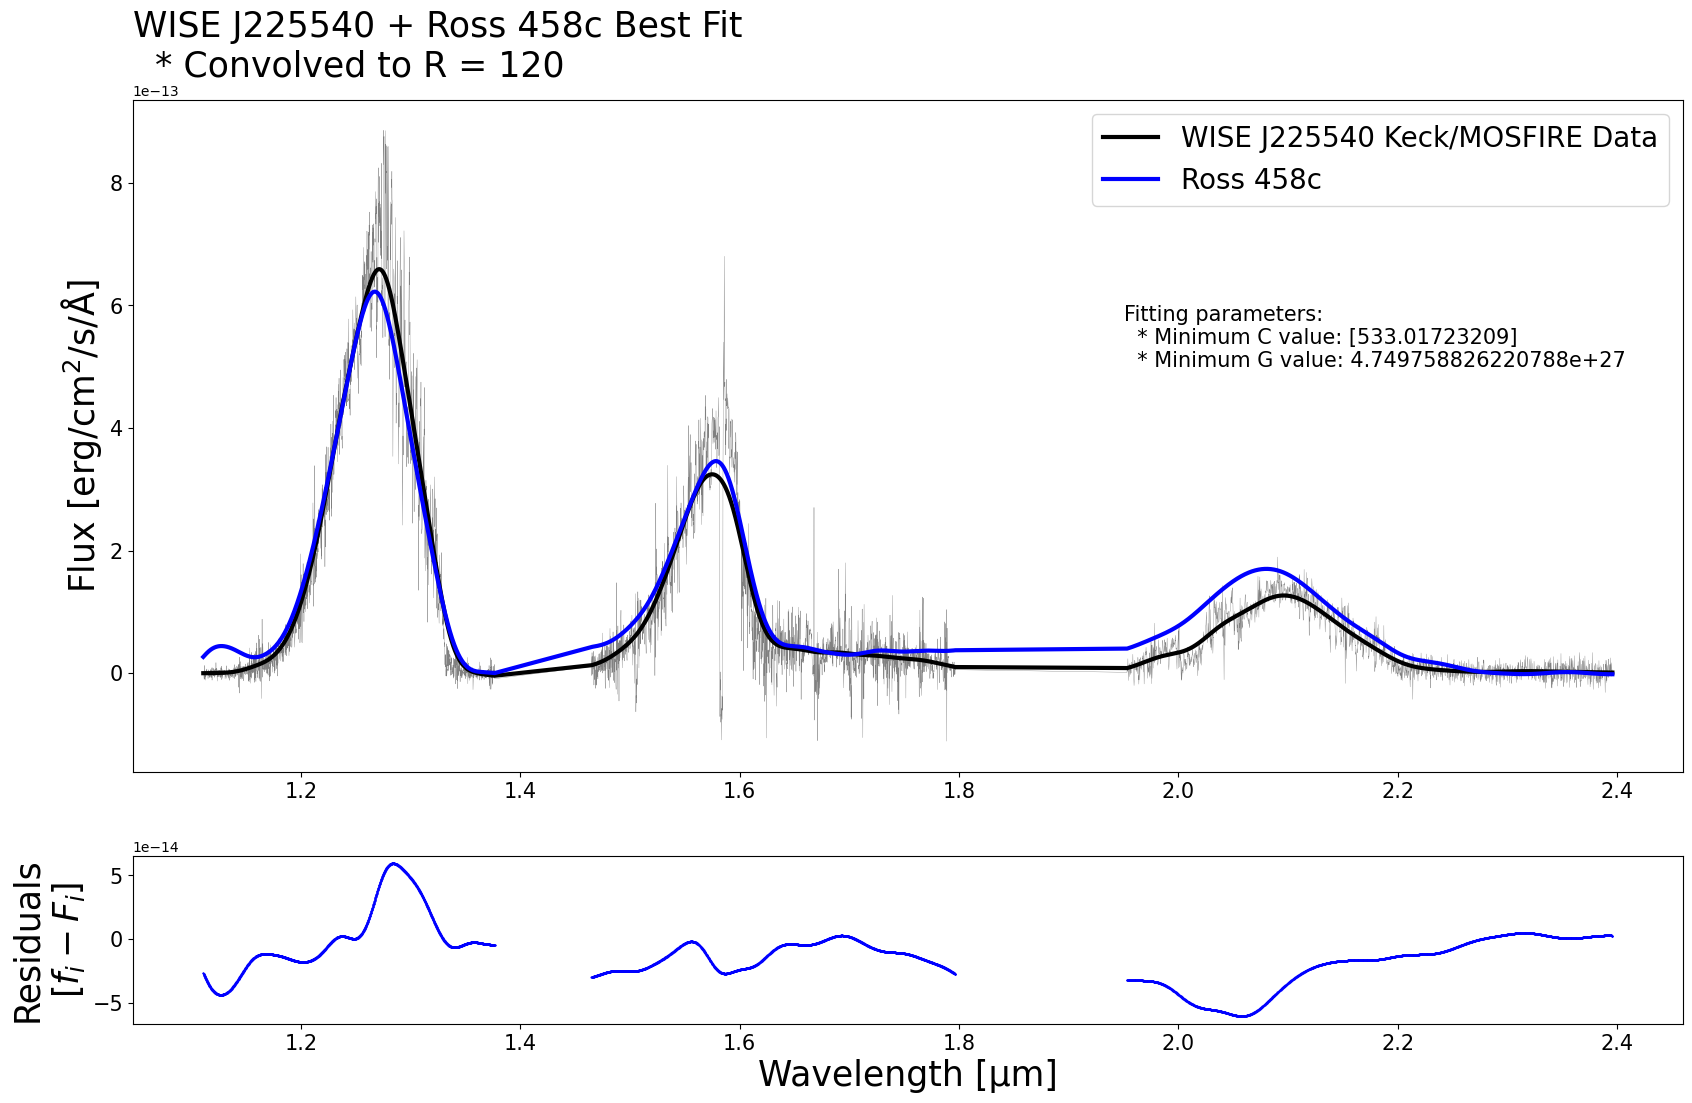

In [62]:
###################################################################
## Smooth and interpolate the SpeX T6 data onto the mosfire data ##
###################################################################

target_short = 'WISE J225540'
C_ross = np.zeros(len(ross_wave))
G_ross = np.zeros(len(ross_wave))
low_mod_ross = np.zeros((len(ross_wave), 2, (len(wave_um))))
for i in range(len(ross_wave)):
    interp_ross = np.interp(wave_um, ross_wave, ross_flux)
    range_ross = np.vstack([wave_um, interp_ross])
    low_mod_ross[i, :, :] = convolve_v2(range_ross, 120, 1)
    C_ross[i] = (np.nansum((low_mod_ross[i, 1, :] * f_smooth) / u_smooth ** 2)) / (np.nansum(low_mod_ross[i, 1, :] ** 2 / u_smooth ** 2))
G_ross = np.nansum(((f_smooth - low_mod_ross[i, 1, :] * C_ross[i]) / u_smooth) ** 2)
G_rossmin = np.min(G_ross)
where_G_rossmin = np.where(G_ross == G_rossmin)
C_rossmin = C_ross[where_G_rossmin]
modindex_ross = int(where_G_rossmin[0])
residuals_ross = f_smooth - low_mod_ross[modindex_ross, 1, :] * C_rossmin

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave_um, flux, color = 'gray', linewidth = 0.25)
ax1.plot(w_smooth, f_smooth, color = 'black', linewidth = 3, label = f'{target_short} Keck/MOSFIRE Data')
ax1.plot(low_mod_ross[modindex_ross, 0, :], low_mod_ross[modindex_ross, 1, :] * C_rossmin, color = 'blue', linewidth = 3, label = 'Ross 458c')
ax1.set_title(f'{target_short} + Ross 458c Best Fit\n  * Convolved to R = 120', loc = 'left', fontsize = 25)
ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 20, fancybox = True)
ax1.annotate(f'Fitting parameters:\n  * Minimum C value: {C_rossmin}\n  * Minimum G value: {G_rossmin}', (1.95, 5e-13), fontsize = 15)

ax2.scatter(w_smooth, residuals_ross, color = 'blue', marker = '.', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
#plt.savefig('Ross 458c Best Fit')

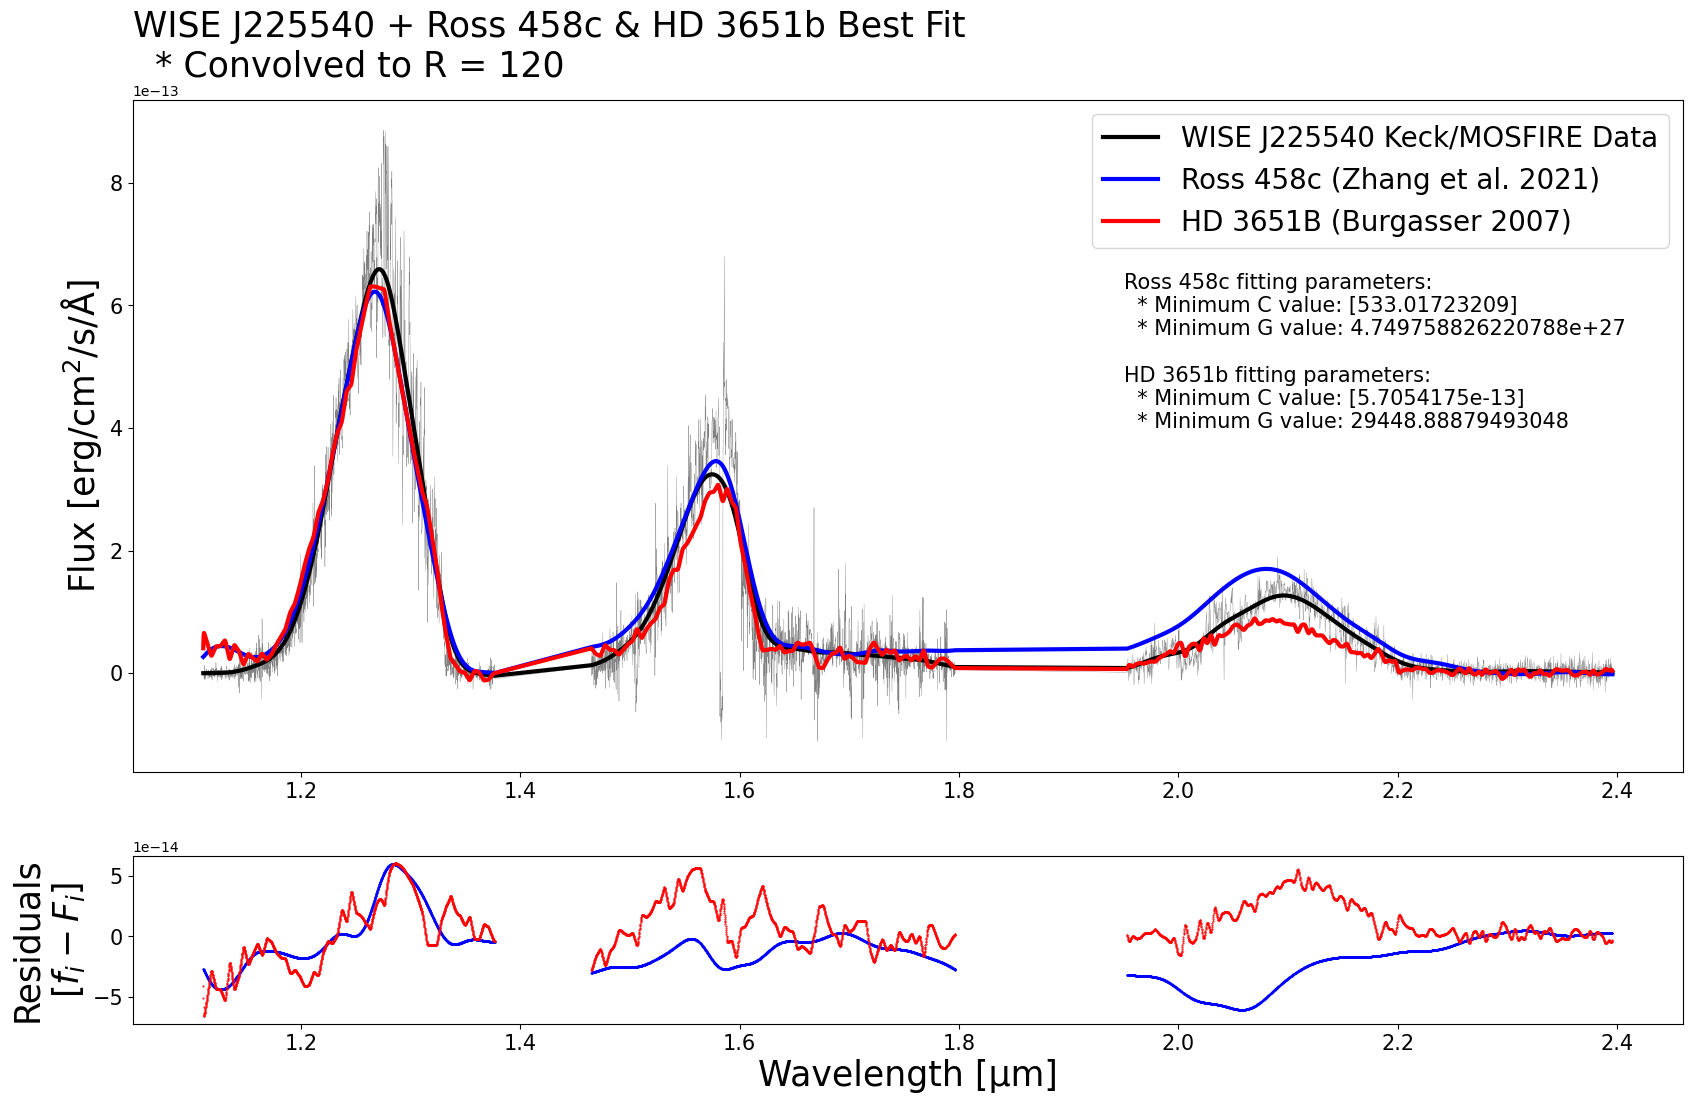

In [92]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20, 12), gridspec_kw = {'height_ratios': [4, 1]})
ax1.plot(wave_um, flux, color = 'gray', linewidth = 0.25)
ax1.plot(w_smooth, f_smooth, color = 'black', linewidth = 3, label = f'{target_short} Keck/MOSFIRE Data')
ax1.plot(low_mod_ross[modindex_ross, 0, :], low_mod_ross[modindex_ross, 1, :] * C_rossmin, color = 'blue', linewidth = 3, label = 'Ross 458c (Zhang et al. 2021)')
ax1.plot(low_mod_t75[modindex_t75, 0, :] * 1e-4, low_mod_t75[modindex_t75, 1, :] * Ct75_min, color = 'red', linewidth = 3, label = 'HD 3651B (Burgasser 2007)')
ax1.set_title(f'{target_short} + Ross 458c & HD 3651b Best Fit\n  * Convolved to R = 120', loc = 'left', fontsize = 25)
ax1.set_ylabel('Flux [erg/cm$^2$/s/Å]', fontsize = 25)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax1.legend(loc = 'upper right', fontsize = 20, fancybox = True)
ax1.annotate(f'Ross 458c fitting parameters:\n  * Minimum C value: {C_rossmin}\n  * Minimum G value: {G_rossmin}\n\nHD 3651b fitting parameters:\n  * Minimum C value: {Ct75_min}\n  * Minimum G value: {Gt75_min}', (1.95, 4e-13), fontsize = 15)

ax2.scatter(w_smooth, residuals_ross, color = 'blue', marker = '.', s = 1)
ax2.scatter(w_smooth, residuals_t75, color = 'red', marker = '.', s = 1)
ax2.set_xlabel('Wavelength [µm]', fontsize = 25)
ax2.set_ylabel(f'Residuals\n'r'$[f_i - F_i]$', fontsize=25)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 15)
#plt.savefig('Ross 458c  and HD 3651b Best Fit')